# DADOS

In [4]:
import deltalake
import pandas as pd
from src.utils import get_path_project

dir_project = get_path_project()
path_deltalake = dir_project / "data/raw/yfinance_api"
path_deltalake_destino = dir_project / "data/staged/stock_history"


df = deltalake.DeltaTable(path_deltalake).to_pandas()

df_pivotado = pd.pivot_table(
    data=df,
    values="y",
    index="ds",
    columns="unique_id"
)
df_pivotado = df_pivotado.dropna(axis=0)
df_pivotado = df_pivotado.reset_index()
df_pivotado.rename(columns={"ds": "datetime"}, inplace=True)
df_pivotado["year_month"] = df_pivotado["datetime"].apply(
    lambda date: date.strftime(format="%Y-%m")
)

In [5]:
df_pivotado.head()

unique_id,datetime,ABEV3,BBAS3,BBDC3,BBDC4,BPAC11,DIS,ITSA4,ITUB4,JBSS3,KLBN11,PETR4,SANB11,VALE3,WEGE3,year_month
0,2017-02-24,13.583568,10.148683,11.377409,11.476044,3.469848,104.355492,4.524377,19.029747,8.211618,9.864655,4.517425,21.034809,18.798416,5.774051,2017-02
1,2017-03-01,13.636866,10.301986,11.122873,11.373029,3.422184,105.036572,4.508918,18.998827,8.253729,9.743732,4.618605,21.120518,19.056955,6.007415,2017-03
2,2017-03-02,13.103880,10.205612,11.010280,11.338319,3.422184,104.610893,4.454756,18.803856,8.225656,9.756465,4.496592,20.857277,18.074520,6.000589,2017-03
3,2017-03-03,13.240933,10.702696,11.163781,11.606318,3.574705,105.225754,4.508918,19.146254,8.134414,9.788285,4.559086,21.249069,18.281349,6.044961,2017-03
4,2017-03-06,13.134335,10.788615,11.216113,11.492929,3.660497,104.686569,4.545026,19.070169,7.804547,9.616447,4.493617,20.991955,17.867689,5.997176,2017-03


# CRIAÇÃO DO MODELO

In [30]:
import torch
import yaml
from src.custom_neural_networks import LSTMModel
from src.utils import get_path_project
from torch import nn

DIR_PROJECT = get_path_project()
CONFIG_PATH = DIR_PROJECT / "config/custom_lstm_config.yaml"

class LSTMModel(nn.Module):
    def __init__(self, num_stocks:int, num_layers_lstm:int, hidden_size:int, output_sequence_length:int) -> float:
        super().__init__()
        self.lstm = nn.LSTM(input_size=num_stocks, num_layers=num_layers_lstm, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_stocks)
        self.output_sequence_length = output_sequence_length

    def forward(self, x):
        # LSTM output shape: (batch_size, input_sequence_length, hidden_size)
        out, _ = self.lstm(x)
        # Slice the last `output_sequence_length` steps and apply FC
        out = self.fc(out[:, -self.output_sequence_length:, :])
        return out  # Shape: (batch_size, 7, 14)


# Load the config file
with open(CONFIG_PATH, "r") as yaml_file:
    config = yaml.safe_load(yaml_file)

# Extract model hyperparameters
model_params = config["model"]
training_params = config["training"]

# Initialize the model
model = LSTMModel(**model_params)

# 
class ModelTrainer():
    def __init__(self, model:nn.Module, num_epochs:int, batch_size: int, learning_rate: float) -> None:
        self.model = model
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.num_epochs=num_epochs
        self.batch_size=batch_size
        self.loss_history = []

    def train(self, dataloader_train) -> None:
        self.loss_history = []
        for epoch in range(self.num_epochs):  # Number of epochs
            self.model.train()
            for X_batch, y_batch in dataloader_train:
                self.optimizer.zero_grad()
                outputs = self.model(X_batch)  # Shape: (batch_size, 7, 14)
                loss = self.loss_fn(outputs, y_batch)  # Compare to target
                loss.backward()
                self.optimizer.step()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")
                self.loss_history.append(loss.item())

    def evaluate(self, dataloader_test):
        self.model.eval()
        with torch.no_grad():
            total_loss = 0
            for X_batch, y_batch in dataloader_test:
                outputs = self.model(X_batch)  # Shape: (batch_size, 7, 14)
                loss = self.loss_fn(outputs, y_batch)
                total_loss += loss.item()

            print(f"Test Loss: {total_loss / len(dataloader_test):.4f}")


        return None
            
model_trainer = ModelTrainer(model, **training_params)

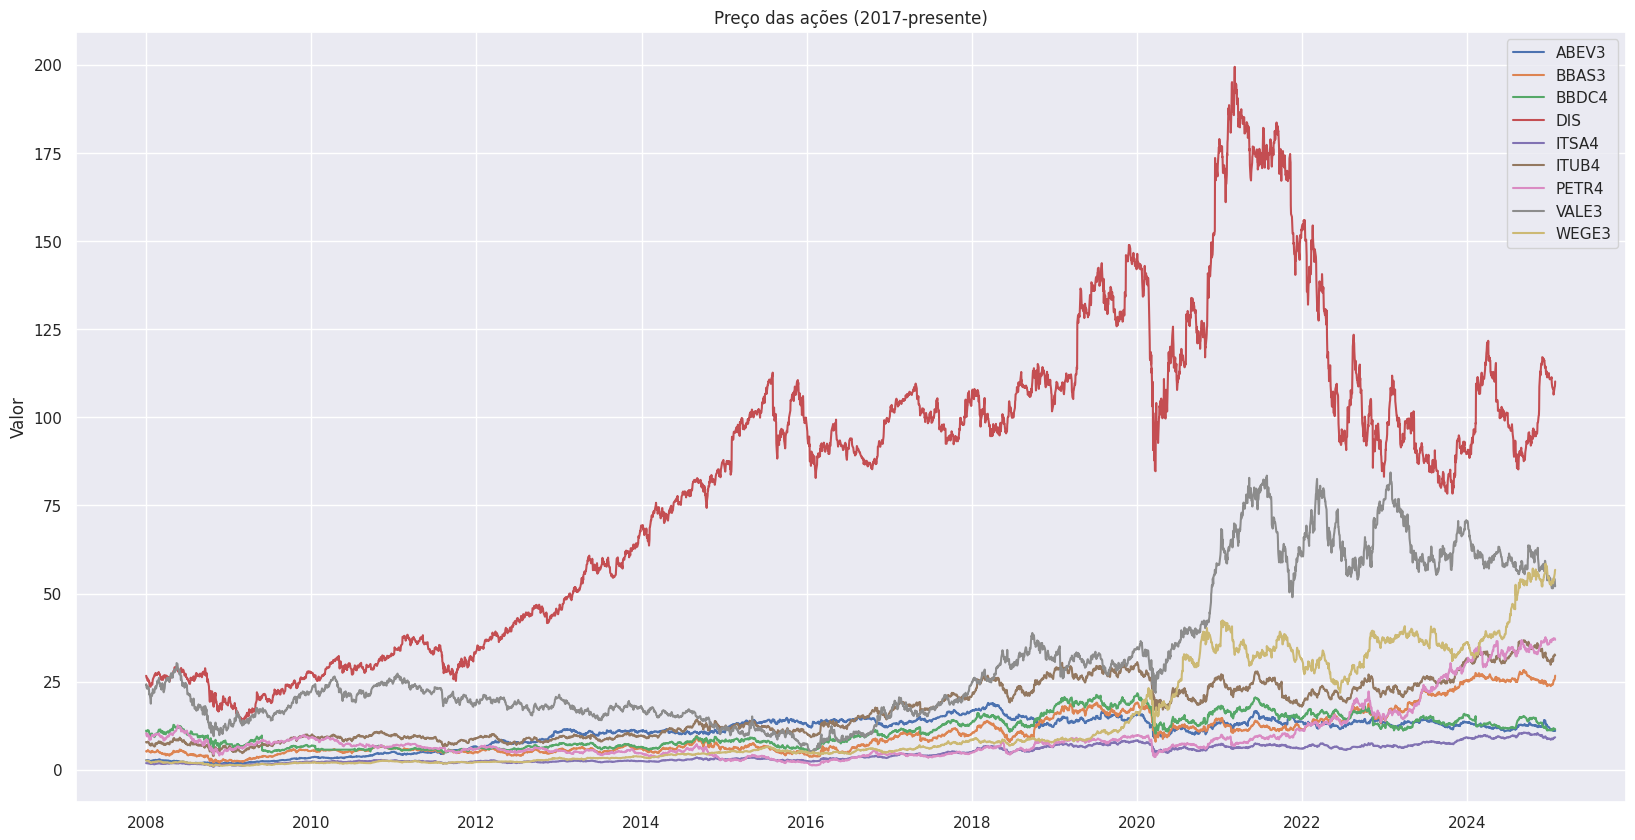

In [31]:
# Bibliotecas
import deltalake
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from src.utils import get_path_project

# Carregando os dados
project_dir = get_path_project()
datalake_path = project_dir / "data/raw/yfinance_api"
df = deltalake.DeltaTable(table_uri=datalake_path).to_pandas()

# Pegando apenas as datas onde todos possuem valor
df_v1 = df.copy()
date_filter = df_v1.groupby("ds")["unique_id"].count() == 9
dates_to_consider = []
for date, to_consider in date_filter.items():
    if to_consider:
        dates_to_consider.append(date)
df_v1 = df_v1[df_v1["ds"].isin(dates_to_consider)].reset_index(drop=True)

# Transformando cada ação em uma coluna com os valores 'y' e o índice será a data
df_v2 = pd.pivot_table(
    data=df_v1,
    values="y",
    columns="unique_id",
    index="ds"
).sort_index()

# Visualizando
sns.set_theme("notebook")
sns.set_style("darkgrid")

plt.figure(figsize=(20, 10))

for col in df_v2.columns:
    sns.lineplot(
        data=df_v2,
        x=df_v2.index,
        y=col,
        label=col
    )

plt.title("Preço das ações (2017-presente)")
plt.xlabel("")
plt.ylabel("Valor")

plt.show()


In [32]:

import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Normalizando os dados usando o MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(X=df_v2.values)

# Criando as sequências (in e target)
num_features_in = df_v2.shape[1]
num_features_out = num_features_in
input_sequence_length = 14
output_sequence_length = 7
total_sequence_lenght = input_sequence_length + output_sequence_length

x = []
y = []

for i in range(data.shape[0] - total_sequence_lenght):
    x.append(data[i:i + input_sequence_length])
    y.append(data[i + input_sequence_length : i + total_sequence_lenght])

x = np.array(x)
y = np.array(y)

# Dividindo em dados de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Transformando em tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Criando os datasets (TensorDatasets)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Criando os  DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [33]:
batch_size, sequence_length, input_features = (1, 14, 9)
A = torch.randn(batch_size, sequence_length, input_features)
lstm_1 = nn.LSTM(input_size=9, num_layers=1, hidden_size=9, batch_first=True)


lstm_2 = nn.LSTM(input_size=9, num_layers=1, hidden_size=9, batch_first=True)

In [34]:
A.shape

torch.Size([1, 14, 9])

In [35]:
lstm(A)[0].shape

torch.Size([1, 14, 9])

In [36]:
linear = nn.Linear(in_features=9, out_features=9)
linear(lstm(A)[0]).shape

torch.Size([1, 14, 9])

In [37]:
y[0]

array([[0.04278632, 0.10798048, 0.27758676, 0.05714678, 0.07871124,
        0.08802384, 0.20224669, 0.17449667, 0.01521922],
       [0.05229208, 0.12182411, 0.32046637, 0.06034253, 0.09005103,
        0.10499282, 0.21883739, 0.20138484, 0.01679242],
       [0.05614581, 0.11946054, 0.326539  , 0.06097268, 0.0909233 ,
        0.103832  , 0.2324595 , 0.20206752, 0.01706679],
       [0.05356377, 0.12351245, 0.3129069 , 0.05840706, 0.09423786,
        0.10626418, 0.23222863, 0.20642646, 0.01845707],
       [0.05100752, 0.12823936, 0.31278281, 0.06115272, 0.09284243,
        0.10488222, 0.23826462, 0.21330598, 0.01981073],
       [0.05357667, 0.12047344, 0.29716768, 0.06308818, 0.08795746,
        0.09758597, 0.23090919, 0.21036518, 0.02026807],
       [0.05935724, 0.1187853 , 0.29518498, 0.06677902, 0.08220054,
        0.0916165 , 0.23519711, 0.22648755, 0.02054246]])

In [38]:
model_trainer.train(train_loader)

Epoch 10, Loss: 0.0011
Epoch 20, Loss: 0.0010
Epoch 30, Loss: 0.0010
Epoch 40, Loss: 0.0010
Epoch 50, Loss: 0.0005


In [39]:
import numpy as np

batch_size, sequence_length, input_features = (1, 14, 9)
A = torch.randn(batch_size, sequence_length, input_features)

model.eval()
model(A)

tensor([[[0.3731, 0.0314, 0.0709, 0.0246, 0.0592, 0.0508, 0.0785, 0.0746,
          0.0155],
         [0.3502, 0.0323, 0.0431, 0.0254, 0.0613, 0.0433, 0.0943, 0.0666,
          0.0230],
         [0.3435, 0.0305, 0.0335, 0.0390, 0.0609, 0.0440, 0.0975, 0.0564,
          0.0260],
         [0.3701, 0.0428, 0.0473, 0.0597, 0.0753, 0.0623, 0.1037, 0.0487,
          0.0340],
         [0.3260, 0.0700, 0.0854, 0.0536, 0.0992, 0.0873, 0.1390, 0.0637,
          0.0331],
         [0.2541, 0.0920, 0.1164, 0.0356, 0.1140, 0.1063, 0.1689, 0.1016,
          0.0236],
         [0.1889, 0.1174, 0.0529, 0.0736, 0.1490, 0.1290, 0.1808, 0.1236,
          0.0239]]], grad_fn=<ViewBackward0>)

In [44]:
for a in model.named_parameters():
    print(a)

('lstm.weight_ih_l0', Parameter containing:
tensor([[ 0.0903,  0.0288,  0.0757,  ...,  0.1370,  0.2807, -0.0670],
        [-0.0356, -0.0931, -0.0691,  ...,  0.0110,  0.2496,  0.2011],
        [ 0.0775,  0.3890,  0.0269,  ...,  0.3050,  0.2434, -0.0204],
        ...,
        [ 0.0480,  0.1461,  0.1582,  ...,  0.2062,  0.1488,  0.1903],
        [-0.1848,  0.0282, -0.1039,  ...,  0.0959,  0.3198,  0.2171],
        [ 0.3160,  0.3751,  0.2743,  ...,  0.3488,  0.1802,  0.1988]],
       requires_grad=True))
('lstm.weight_hh_l0', Parameter containing:
tensor([[ 0.1256,  0.0877,  0.2096,  ..., -0.1103,  0.1920, -0.1908],
        [ 0.0791,  0.0599,  0.1591,  ..., -0.1108,  0.1636, -0.0627],
        [ 0.2021, -0.2243,  0.0367,  ..., -0.3387,  0.0416, -0.0345],
        ...,
        [ 0.2467, -0.2041,  0.0954,  ..., -0.0233,  0.0234, -0.1158],
        [ 0.0192,  0.1391, -0.1728,  ...,  0.1193,  0.0015,  0.0698],
        [ 0.2485, -0.1965,  0.0715,  ..., -0.2900,  0.0458, -0.1987]],
       requires_

In [ ]:
for a in 